### transformer的变体
#### 架构
 - 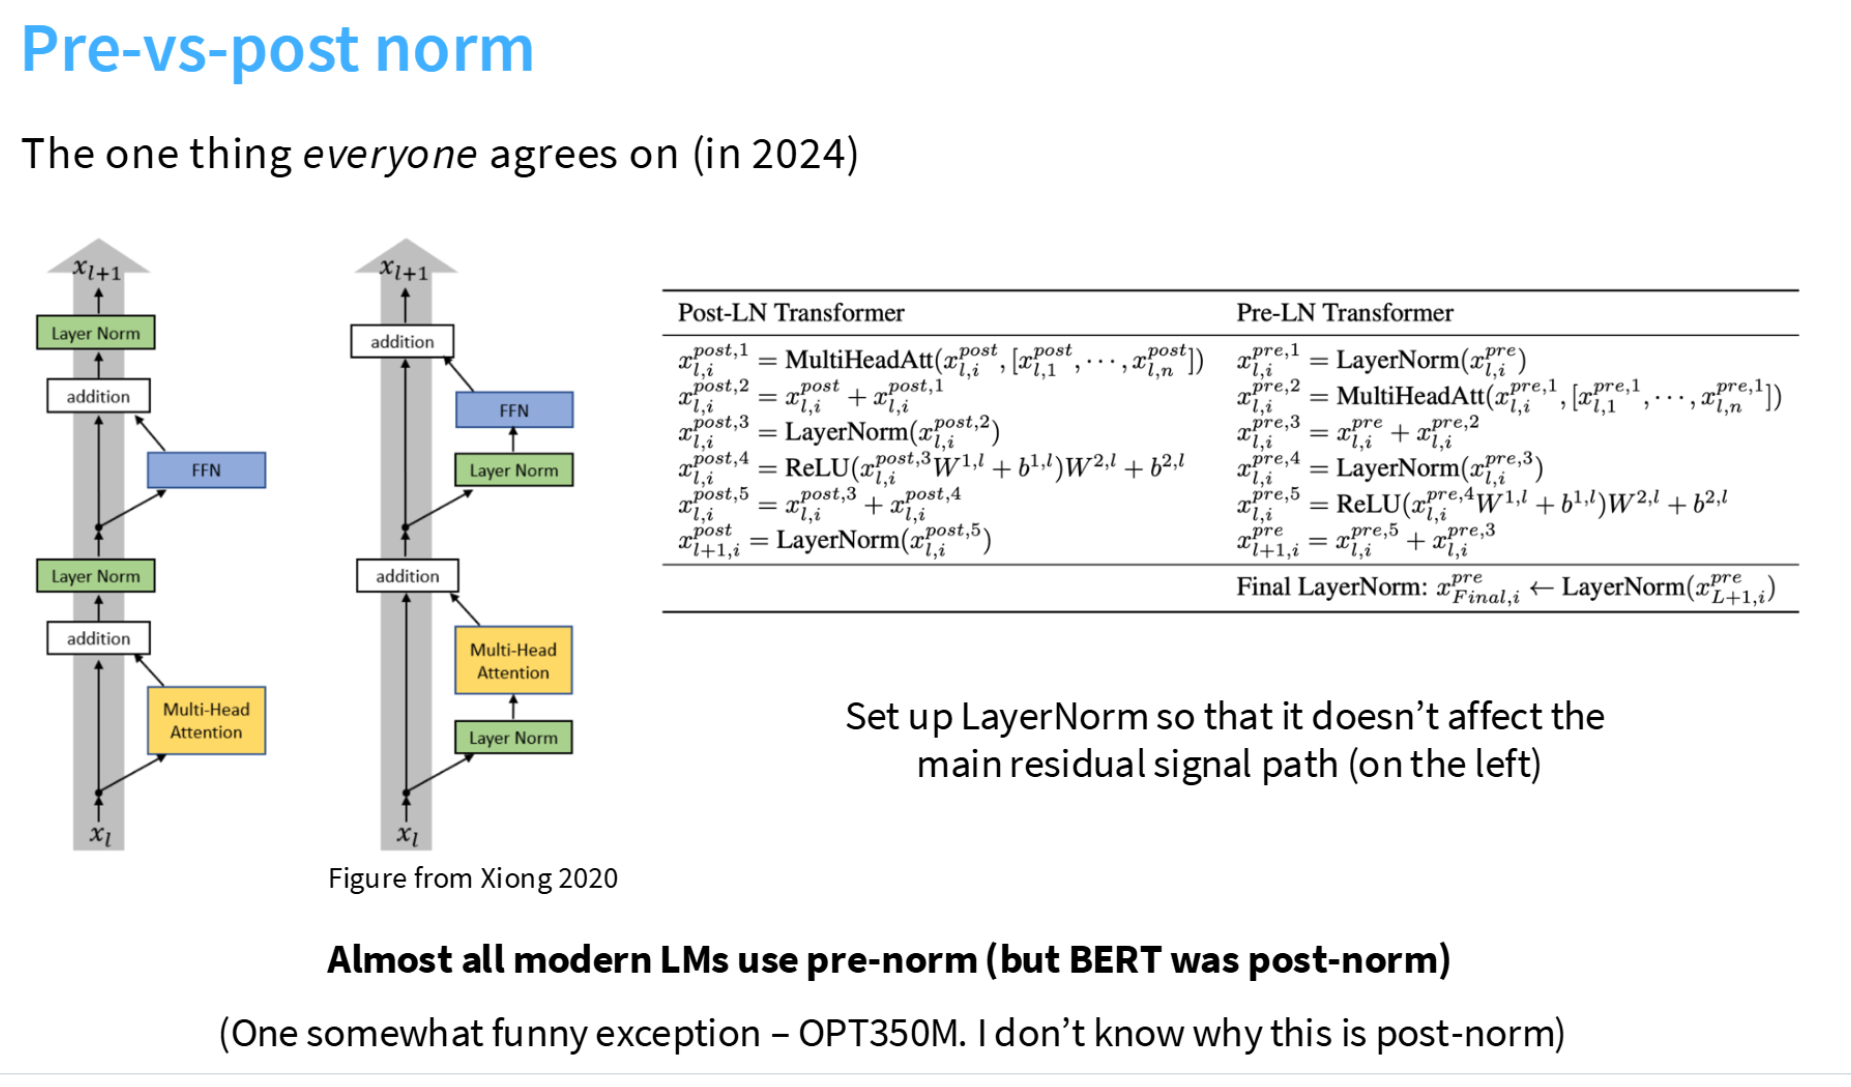
 - 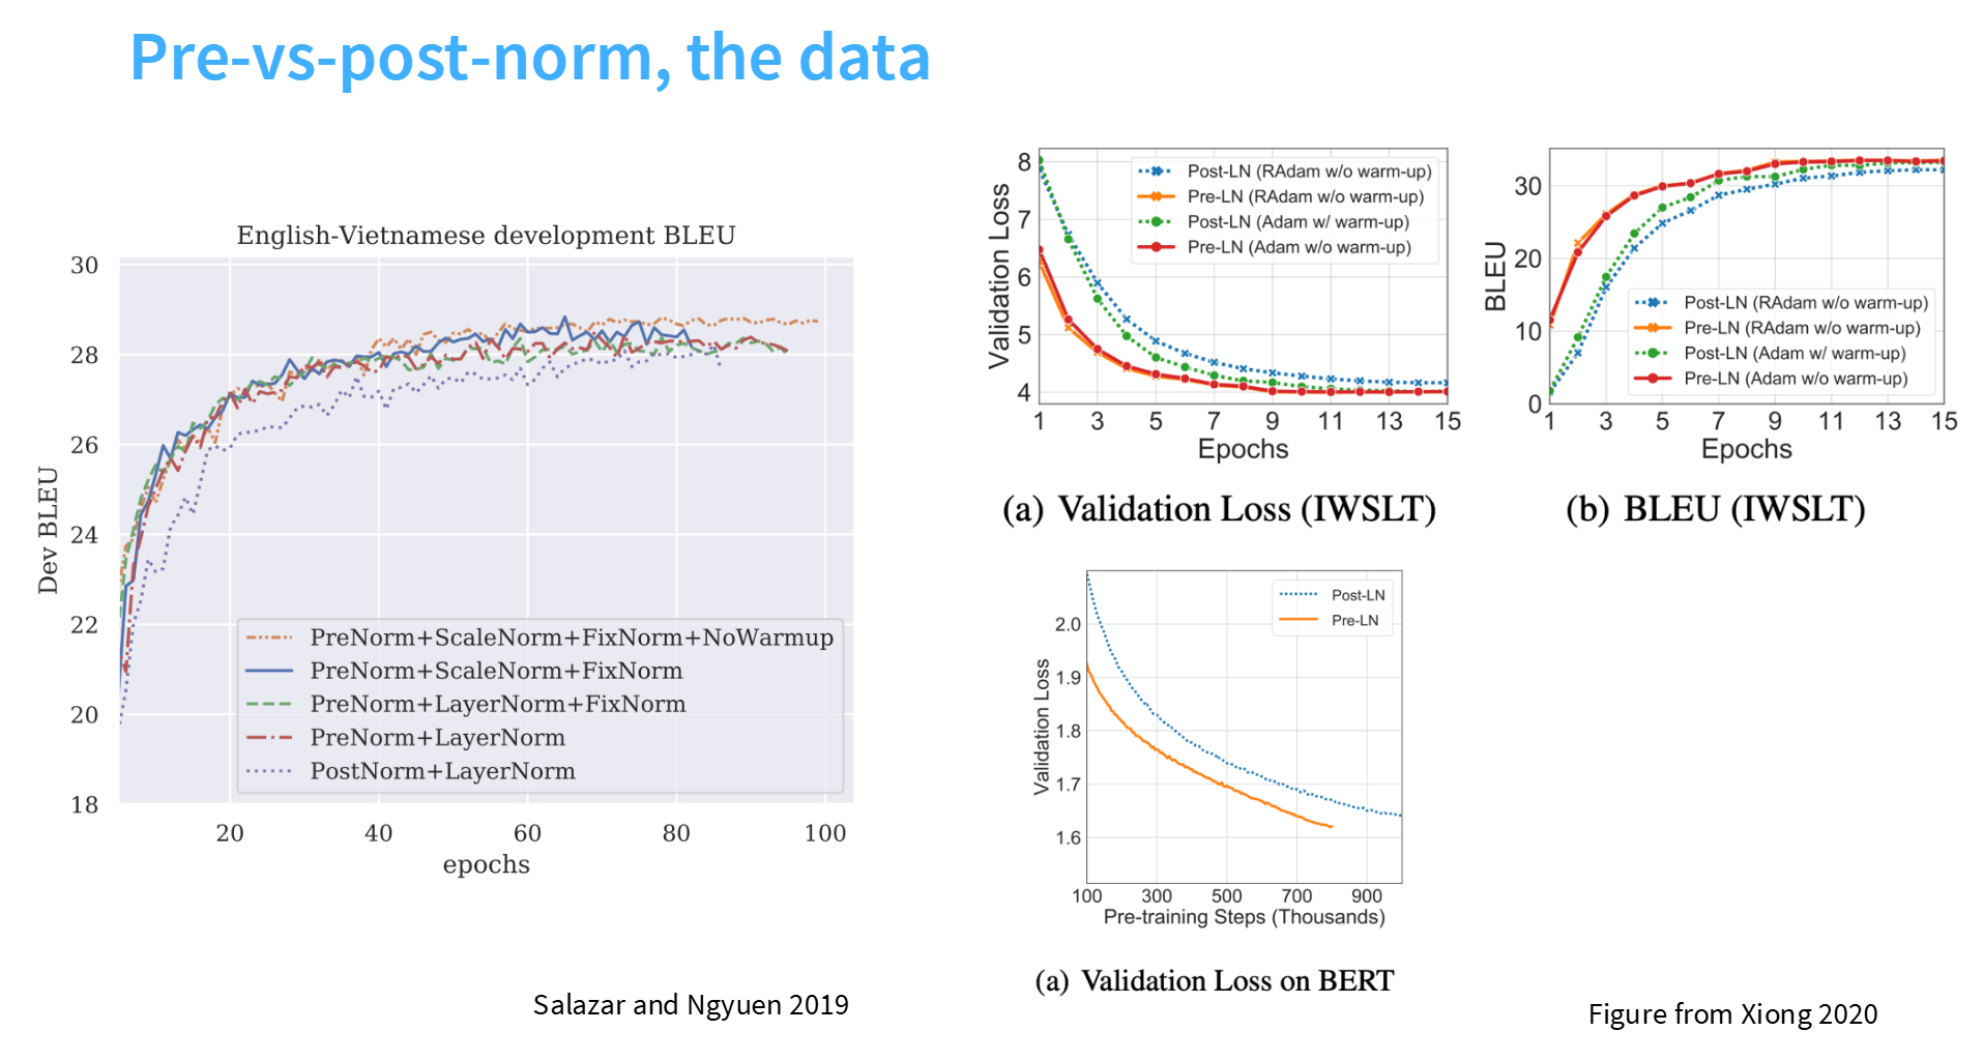
**Pre-Norm（预归一化）**
工作顺序：
1. LayerNorm → 
2. Attention 或 Feed-forward → 
3. Residual Connection（残差连接）
优势：
 - 在梯度反向传播时，梯度的稳定性通常较好，因为归一化层能确保输入在每一层都有相对均匀的分布。
 - **训练稳定性较高**，尤其是在深层网络中，训练过程中的梯度爆炸/消失问题得到缓解。

#### 另一种形式：用两个layernorm
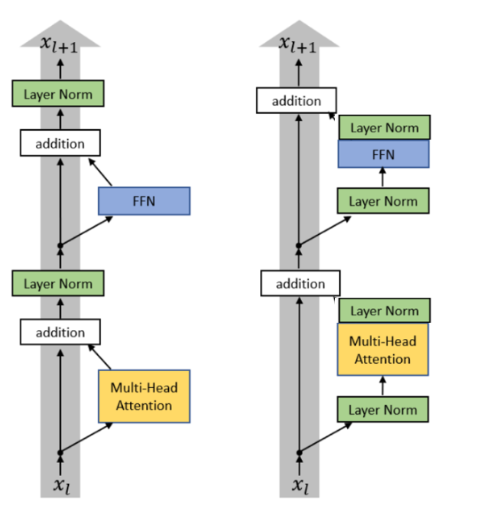

### LayerNorm to RMSNorm
 - RMSNorm相比于LayerNorm的优势在于在计算的时候不用计算均值，减去均值,但是同样可以有好的性能，而且在实验中还表现出更小的loss
 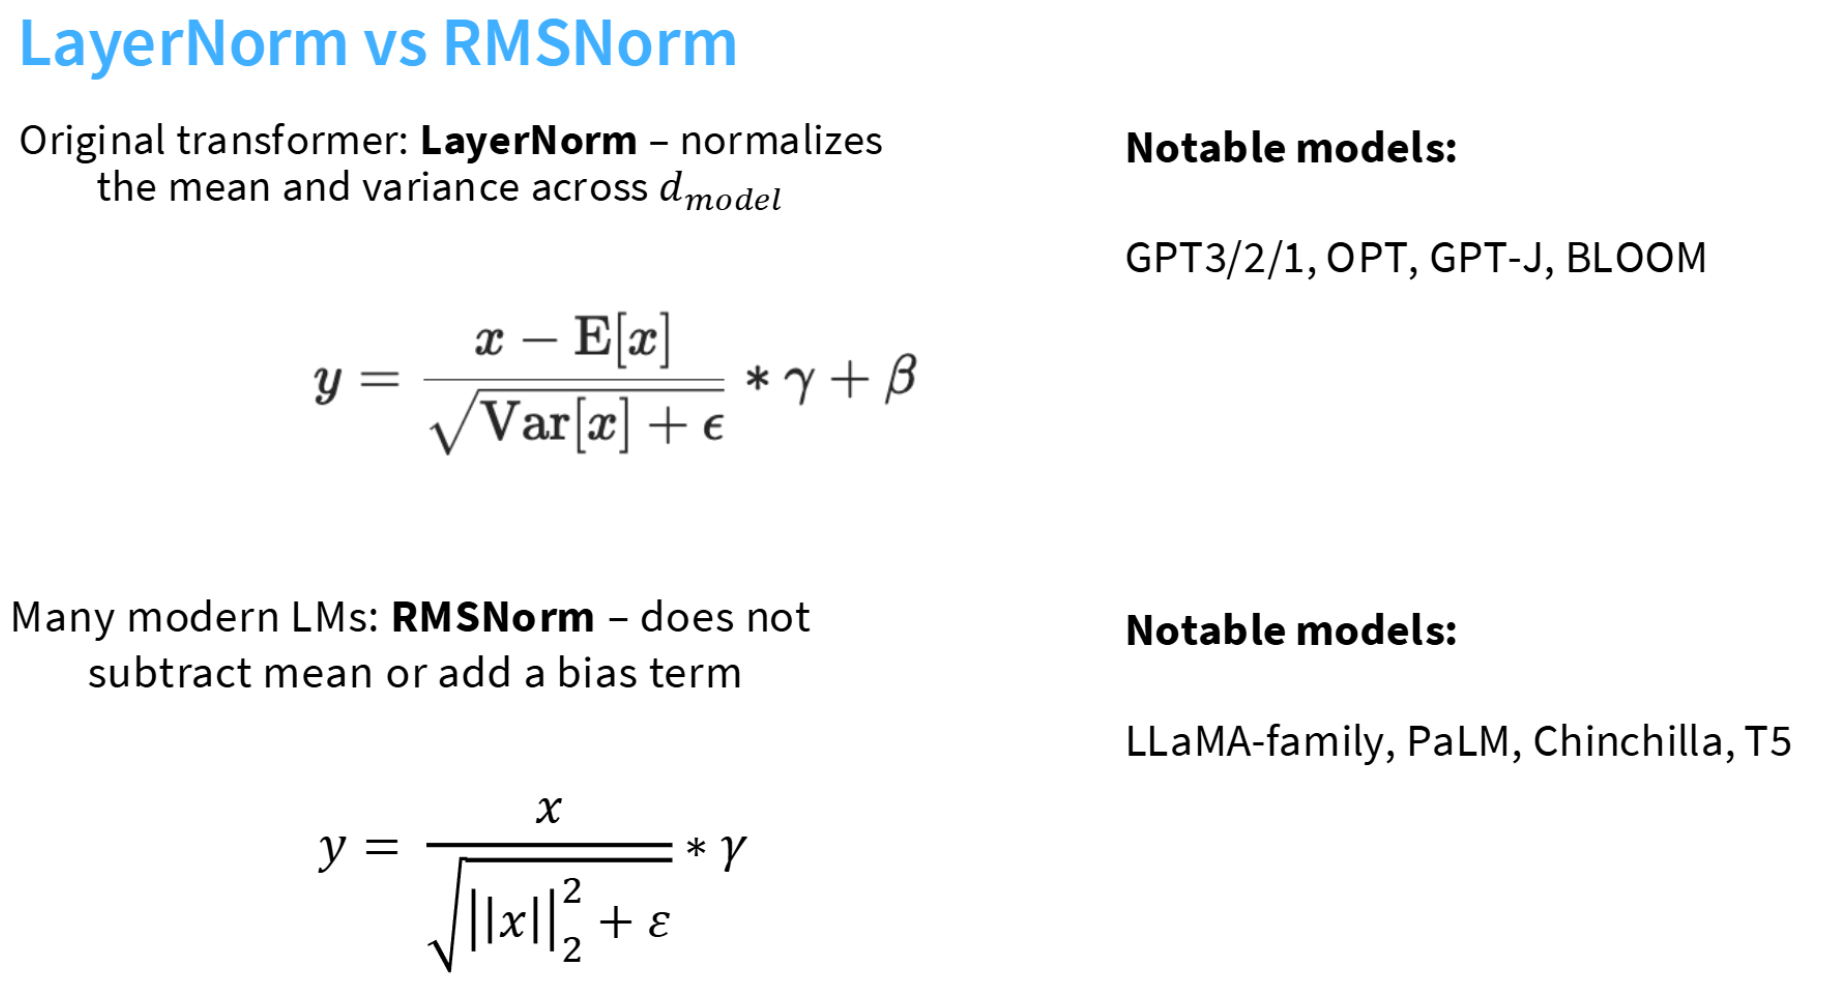
 - 所谓的性能提升体现在哪里呢？
    - 在下面这张图中可以看出，有99.8%的flop都被花在了matrix计算上，花在norm中的时间并不多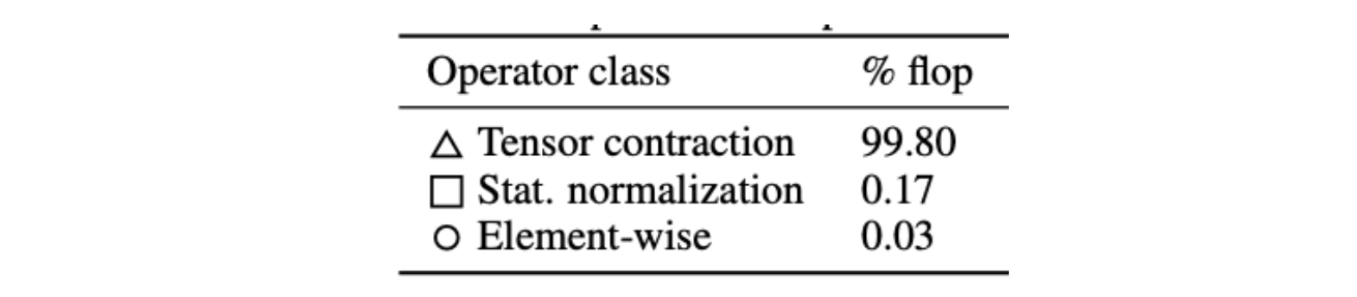
    - 但是FLOPS并不能代表运行时间，还要考虑data Move（内存移动），所有在runtime中norm的占比还是很大的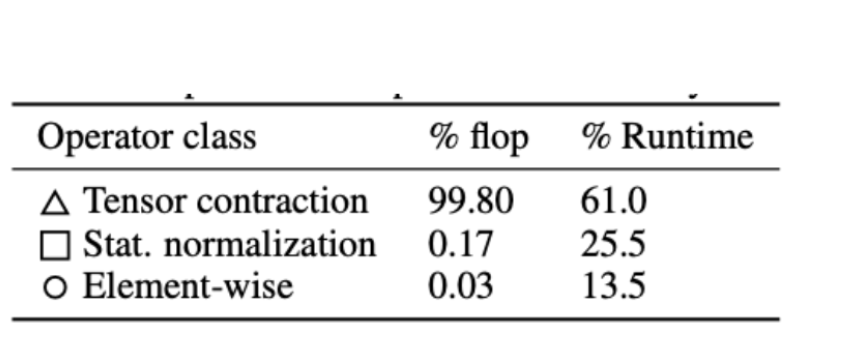

### 取消bias term
 - 减少计算，只要使用矩阵乘法
 - 提高稳定性
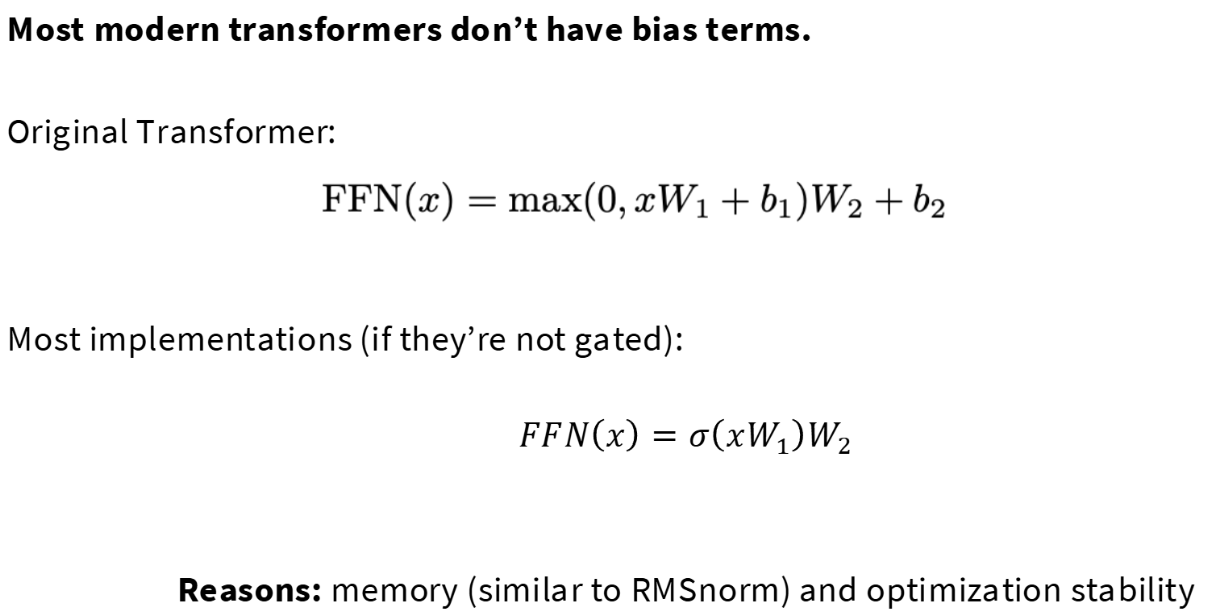

### activation的选择
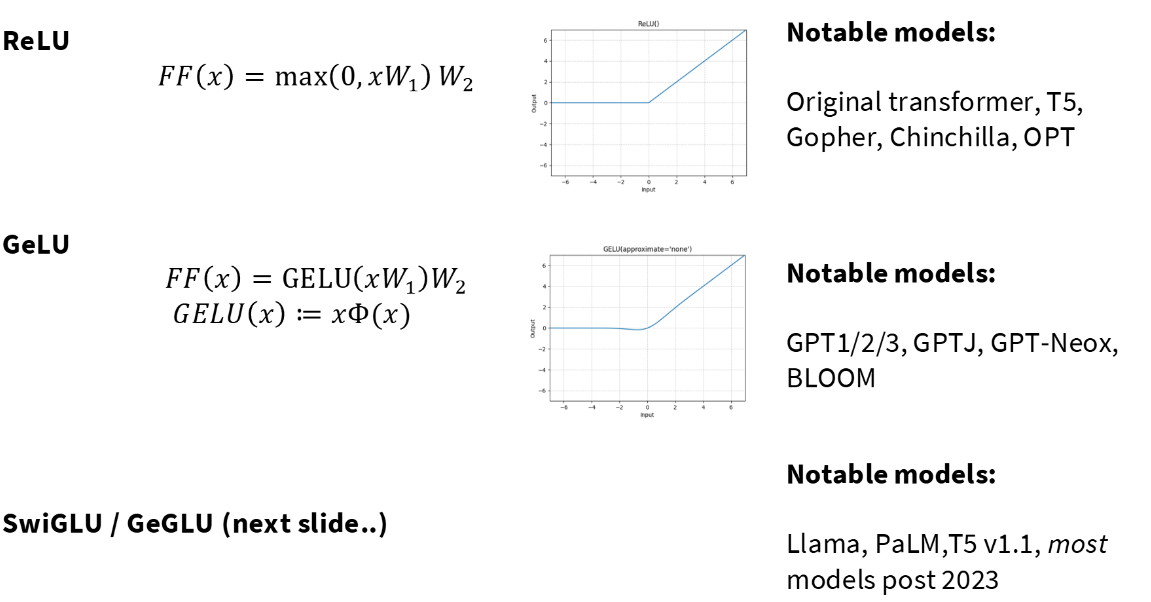
### 目前大多数人使用的：*GLU
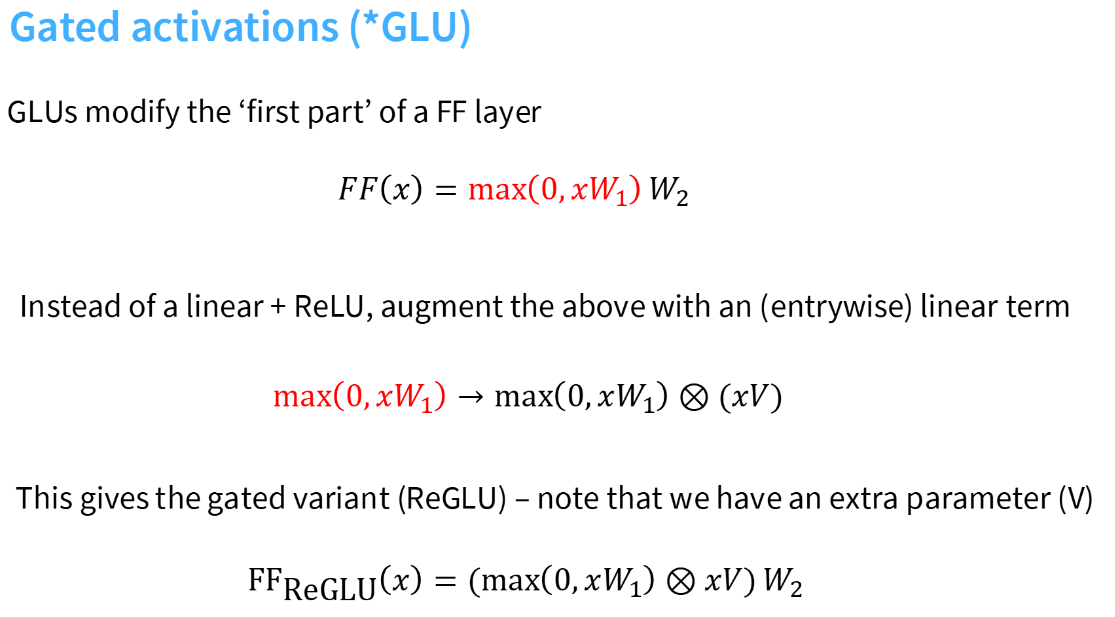
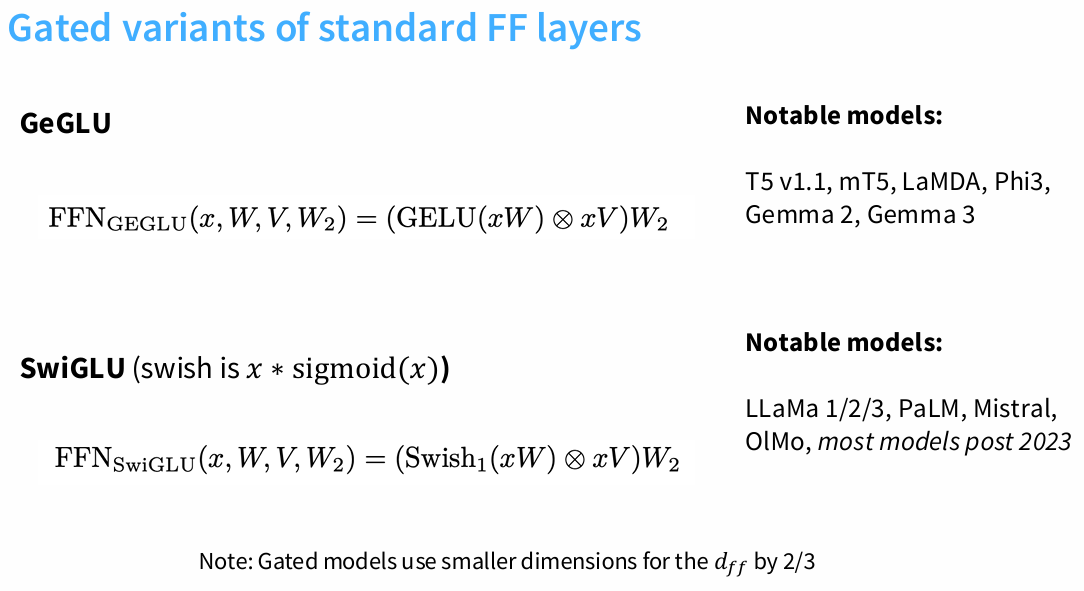

### parallel layers
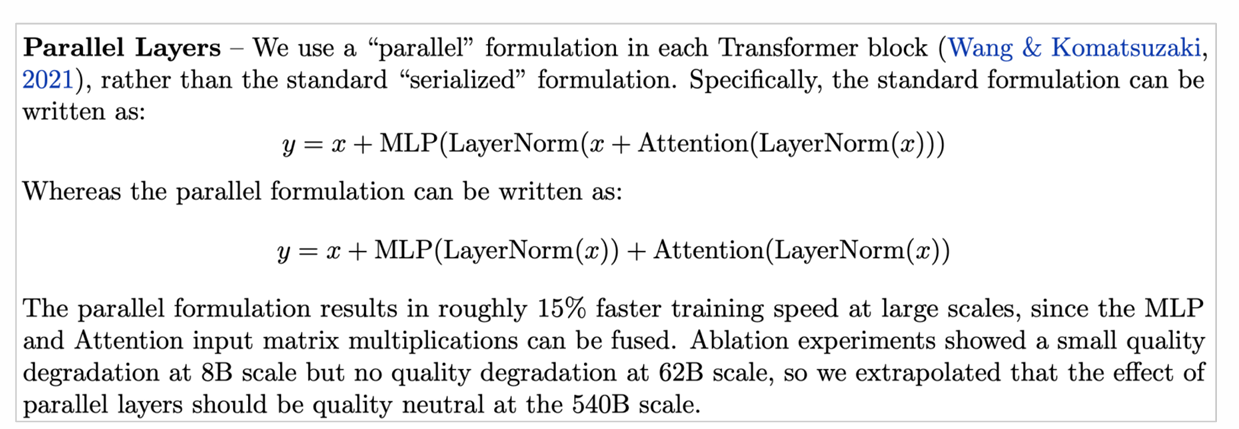

### position embedding的变体——RoPE
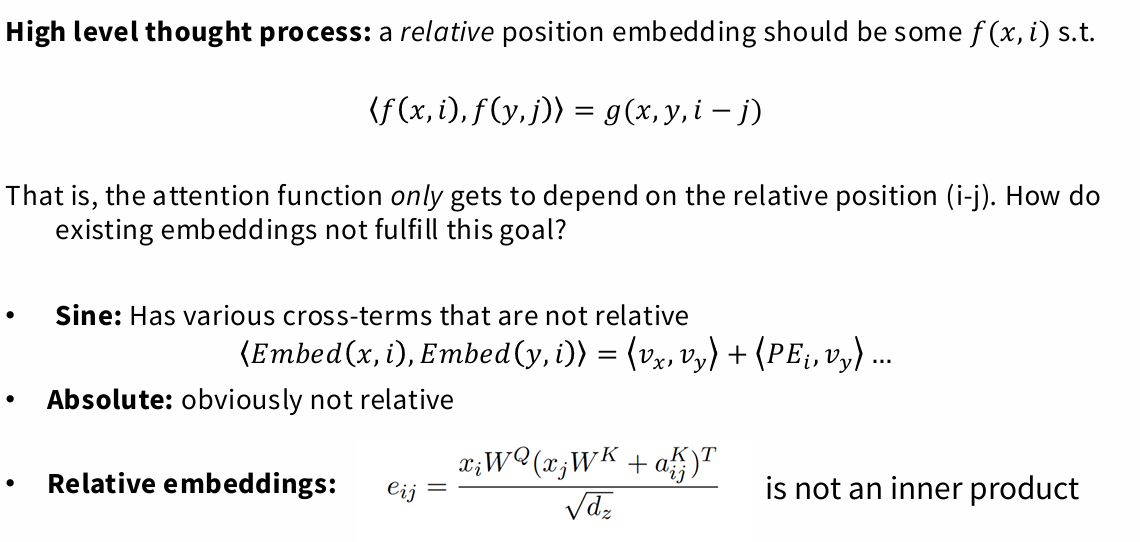
 - f(x,i)中x是当前值，i是位置（图上的公式要求两次词需要满足**相对位置不变性**），并且两者之间的关系可以写成**内积的形式**，相比于下面的这些，RoPE不会泄漏绝对位置信息
 - 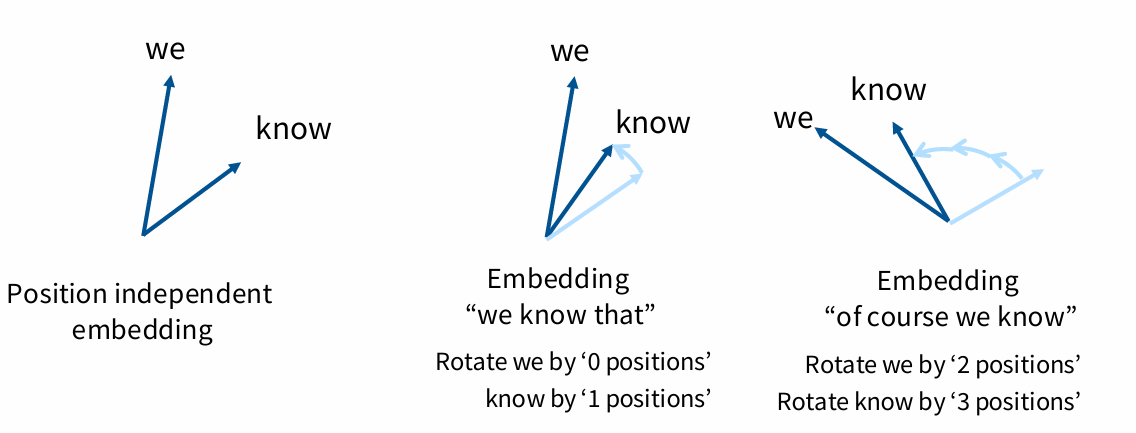旋转角度由位置信息决定，如果两者的相对位置不变，那么内积就不会改变
 - 在高维空间中不同于二维：要使用高维向量，切削成二维的块，每两个维度都旋转一个角度，需要成对的旋转，然后维度对旋转速度不同，能够捕获的位置信息的远近就不同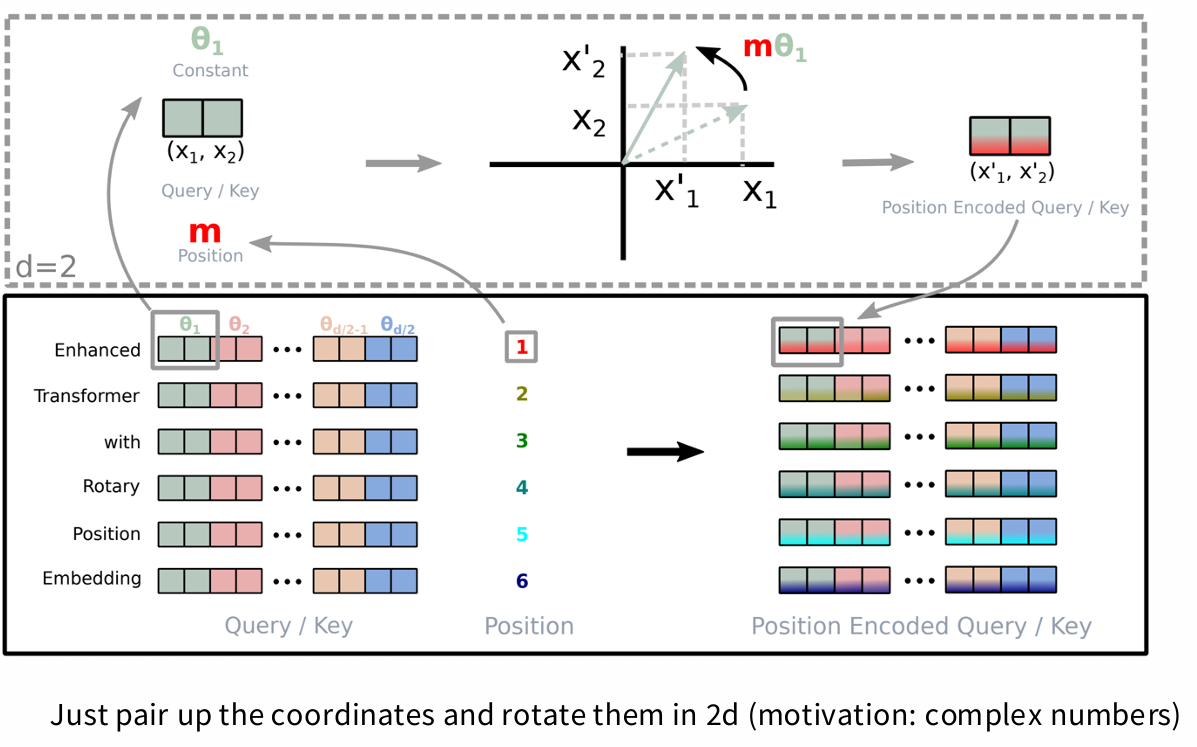用三角函数的知识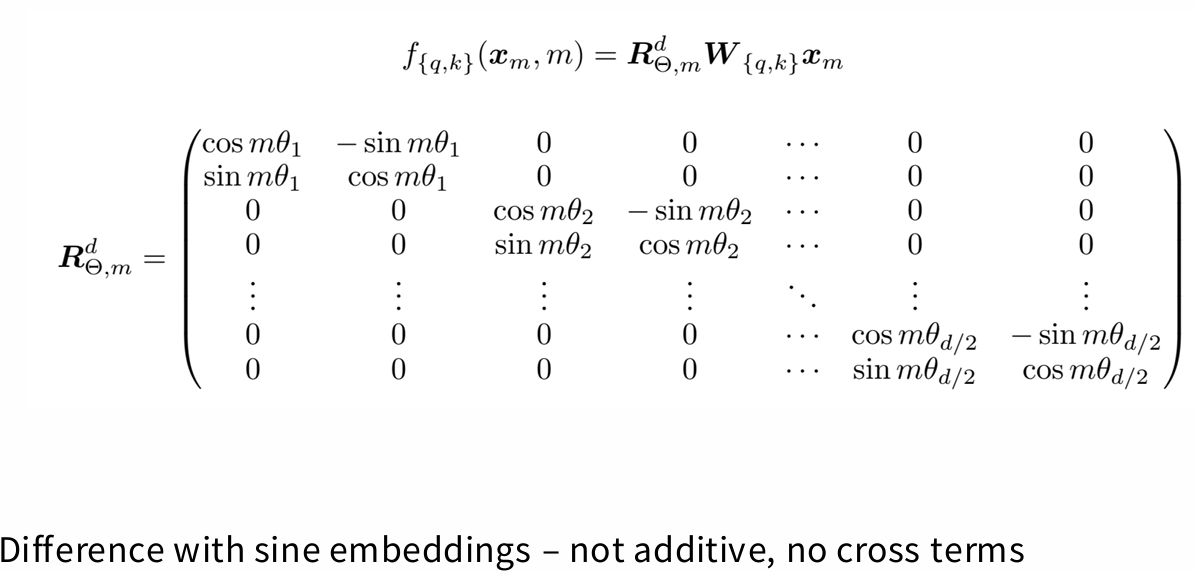

 #### 代码
 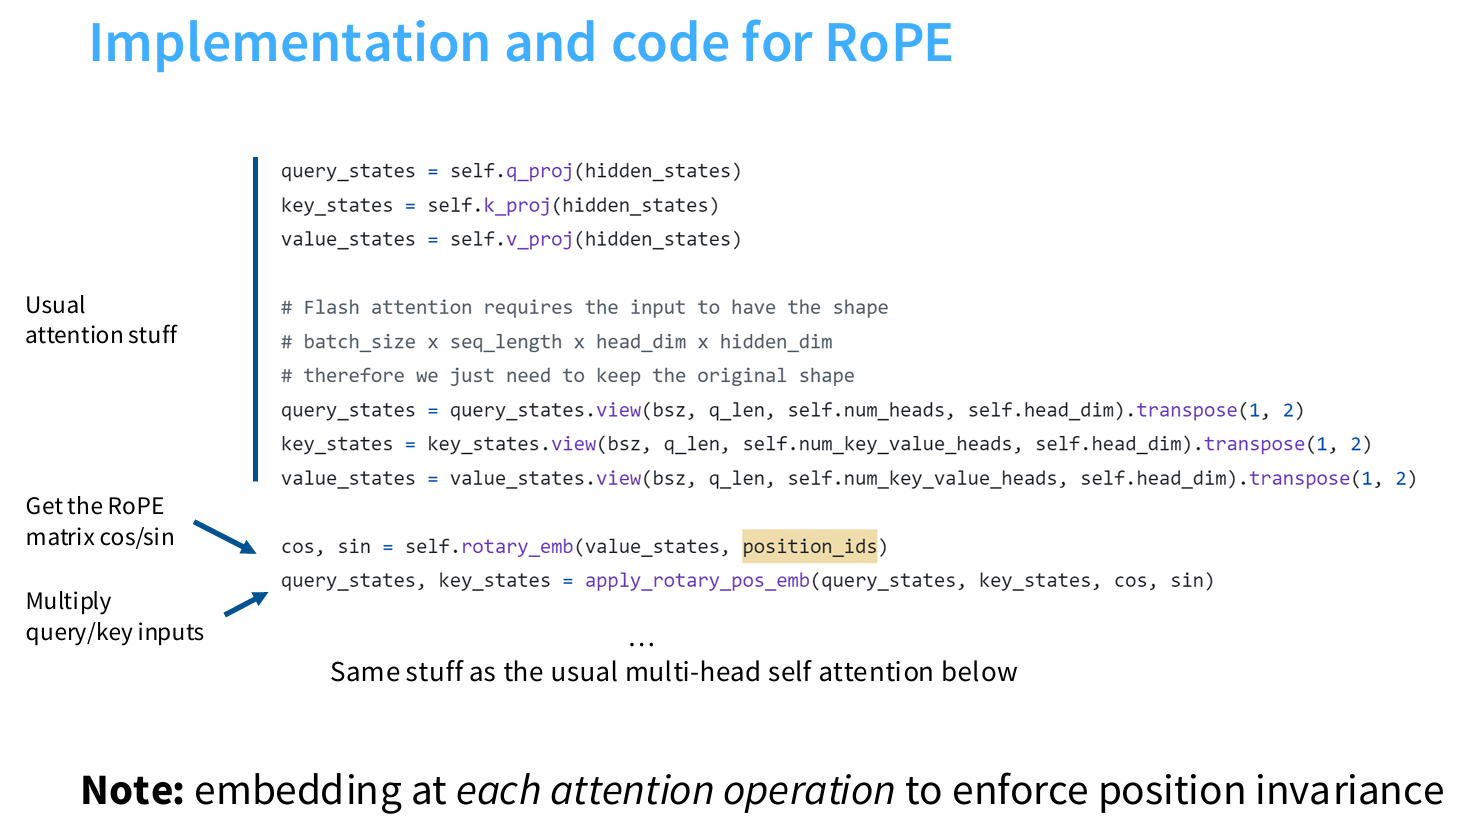


## Hyperparameyters
Transformer hyperparameter questions you might have had in 224n.
1. How much bigger should the feedforward size be compared to hidden size?
2. How many heads, and should num_heads always divide hidden size?
3. what should my vocab size be?

### in a simple feedforward layer
 - a Relu version:
 $$FFN(x) = max(0,xW_1 + b_1)W_2 + b_2$$
 - 两个超参数：
     - D model:the dimensionality of X,MLP的输入
     - d_{ff}：feedforward dimension,隐藏层的维度
     - 通常隐藏层的维度要比输入层多：向上投影
         - Relu通常使用：$d_{ff} = 4 \times d_{model}$
         - GLu如果需要得到相同的参数数量，需要4乘以2/3 = 8/3 = 2.66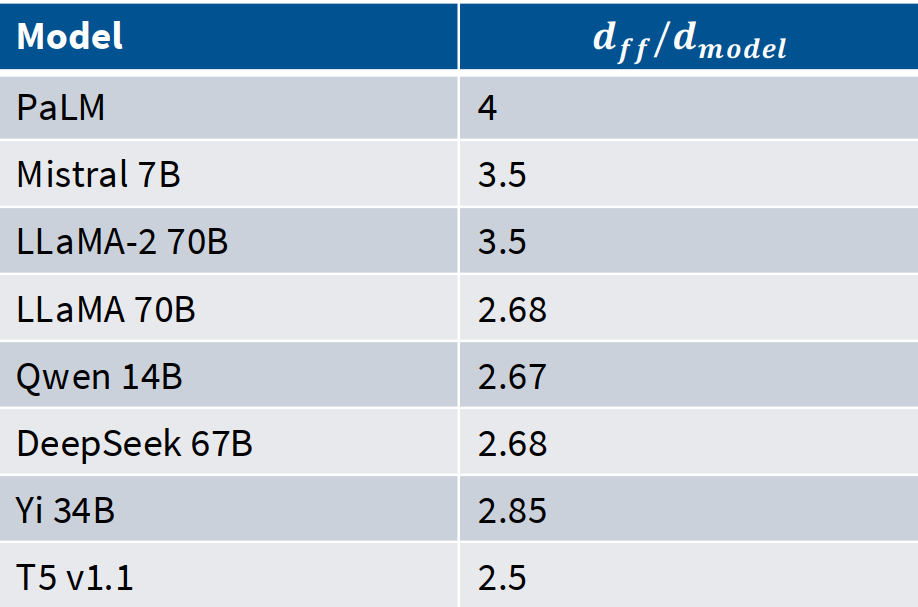 
         - 有时会使用很大胆的比例，比如goegle（T5）有𝑑𝑓𝑓 = 65,536，𝑑𝑚𝑜𝑑𝑒𝑙 = 1024
         - 根据图像，其实选择1-10之间都可以![alt text](image.png)
     - 这个系数的含义是：这个比例越大，那么需要并行计算的东西就越多，那么矩阵乘法可以传递更多的信息，但是计算量也更大


### multihead attention：Head-dim*num-heads to model-dim ratio
 - 在增加input dim 的时候，到底是继续给每个头均分dim还是增加新的头
 - 通过以下公式计算这个 ratio：head-dim / (model-dim / num-heads)
    - Head Dim 是单个头的维度。
    - Model Dim 是整个模型的维度。
    - Num Heads 是头的数量。
 - 大部分模型把这个取值为1

### 模型的宽度和深度
 - $n_{layer}$:宽度通常指的是每一层中的神经元或特征的数量
 - $d_{model}$:深度也就是层数
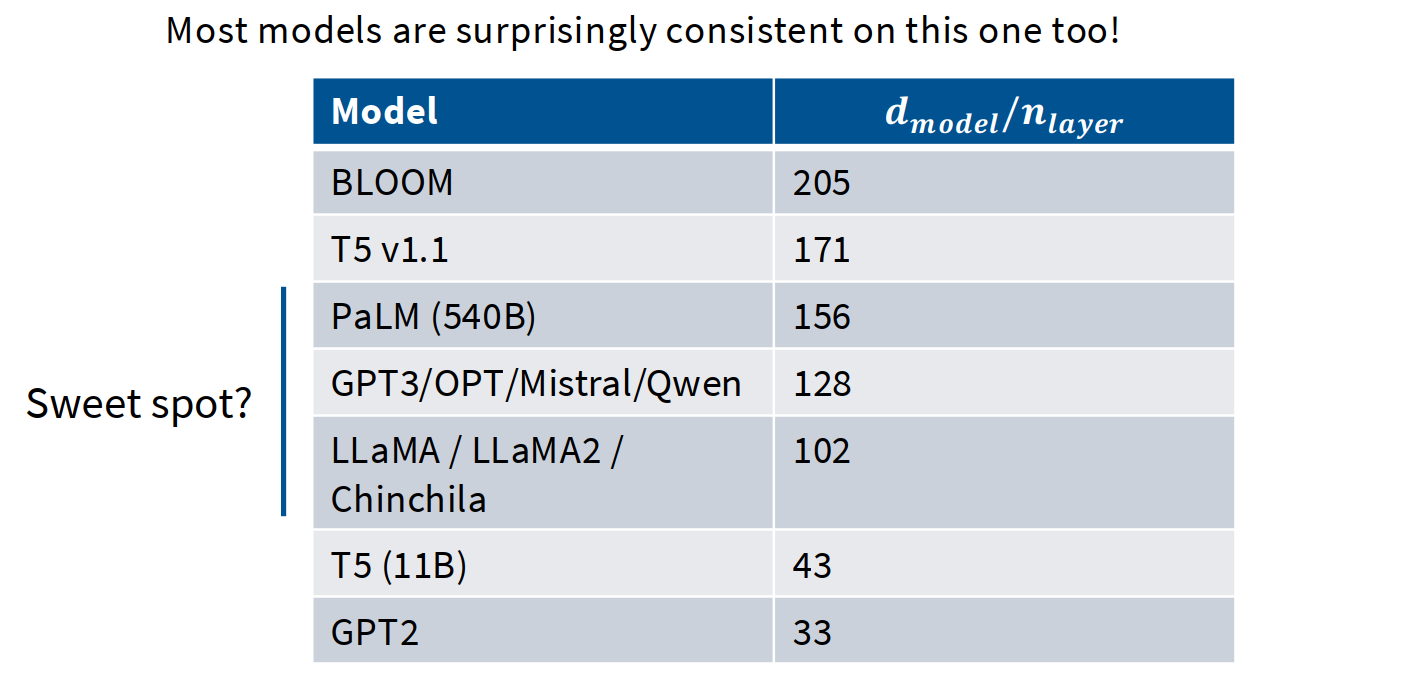

 - 如果有比较宽的模型，可以做张量并行（每一个层内部的并行，需要快的网速）
 - 如果有比较深的模型，每一层的计算都要等待上一层的计算（相当于是串行，所以会造成性能瓶颈）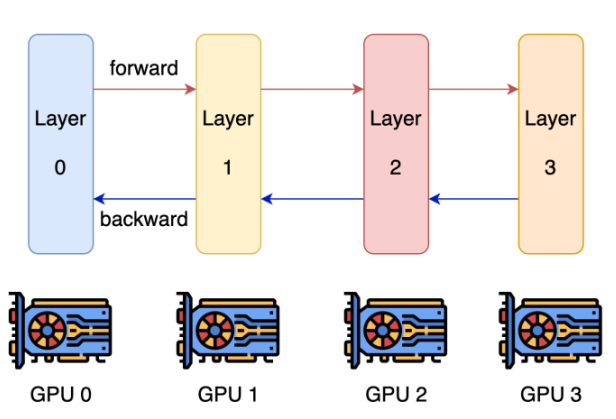
 - sweet region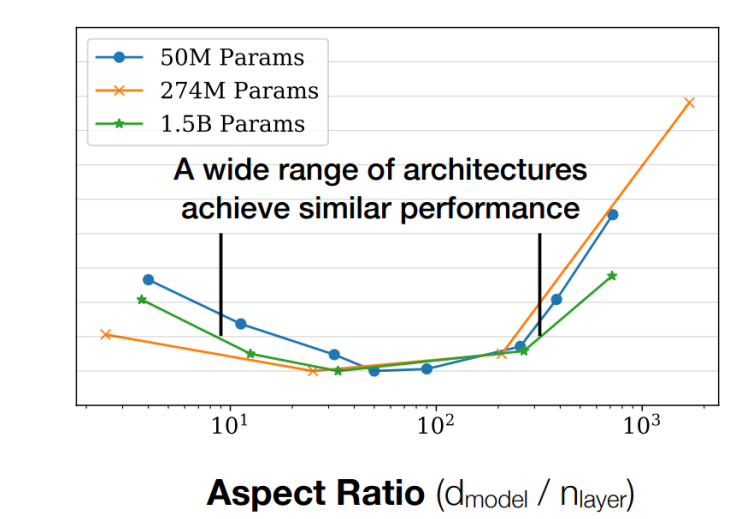

### vocabulary size
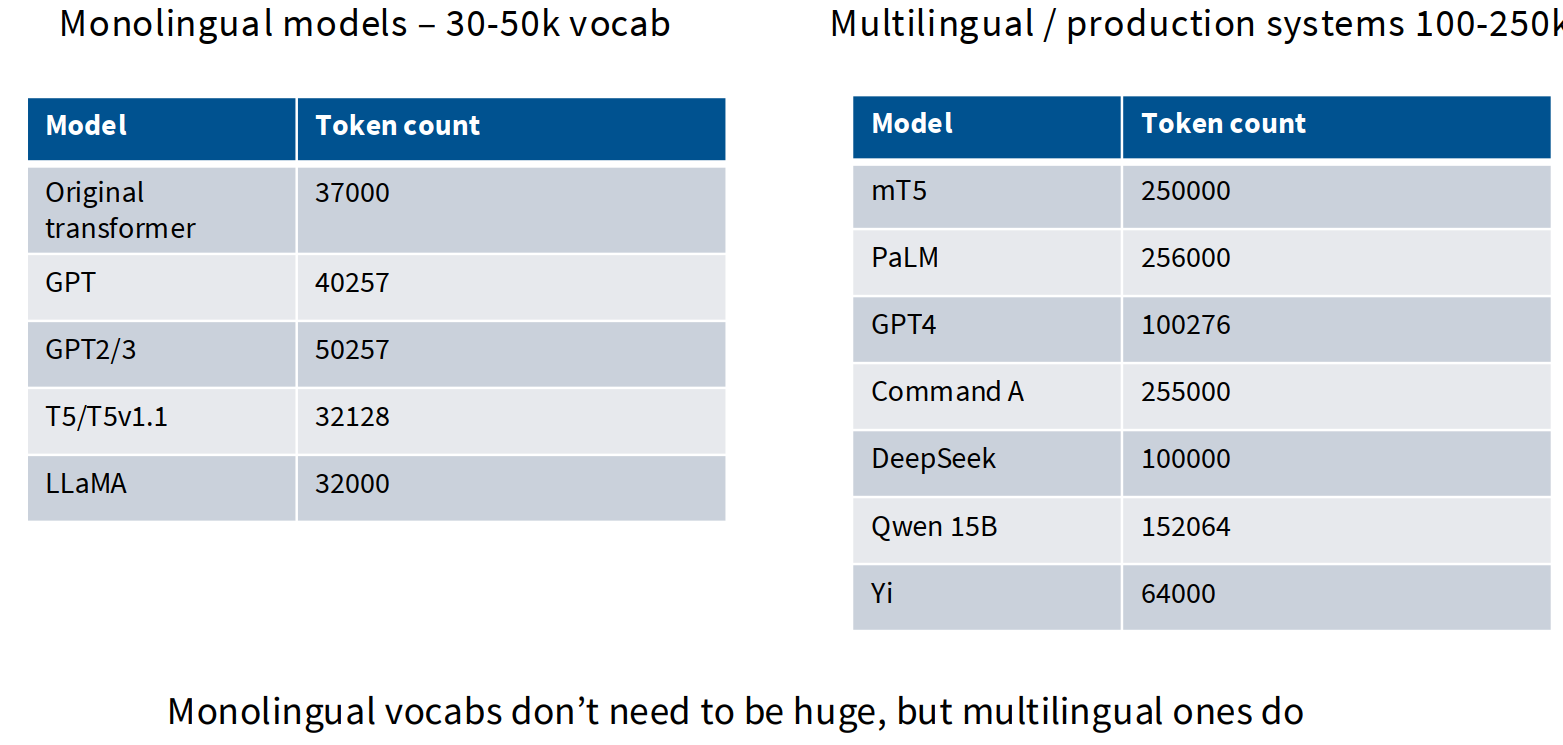
 - vocabulary size 越大，越多的词汇可以被习得

And other model setting questions
 - Do people even regularize these huge LMs?
 - How do people scale these models - very deep or very wide?

### 在预训练阶段，**正则化regularization**的必要性通常是一个有争议的问题。


#### 反对的观点
1. 大量数据（训练数据多于参数）
观点：预训练过程中使用的数据量非常大，通常是 数万亿（trillions）个token。在这种情况下，训练数据的规模远远超过了模型的参数量。

解释：当数据量如此庞大时，模型就有更多的机会从数据中学习到一般化的模式，而不仅仅是“记住”训练数据中的特定信息。因此，模型可以从大量的训练数据中提取到有用的信息，而不会轻易出现过拟合（memorization）。这使得正则化的需求看起来不是那么紧急。

2. SGD 只进行一次遍历（难以记住）
观点：在训练时，随机梯度下降（SGD） 通常对数据集进行 一次（单次）遍历，每个样本仅被用来更新模型一次。这种一次性处理数据的方式使得模型更难去“记住”训练数据中的细节（即过拟合）。

解释：因为训练过程中的每次权重更新都是基于一个小批量的数据，而不是整个数据集，所以模型很难记住（或过拟合）训练数据的细节。再加上，预训练的目标是通过无监督学习（如语言建模）从大量的文本中学习广泛的语言模式，模型更多地是在学习这些模式而不是记住特定的训练样本。

#### 实践中，许多模型在预训练阶段仍然使用了正则化技术
Dropout：即在训练过程中，随机丢弃一部分神经元，以防止模型过拟合。尽管数据量很大，但 Dropout 依然被广泛应用，帮助模型在复杂的任务中提高泛化能力。

**Weight decay（L2 正则化）**（目前最常用）：通过对模型的权重施加约束，限制其过大，从而防止过拟合。

Early stopping：虽然这通常用于验证集上，但在某些情况下，它也可以防止模型过度训练并减少过拟合。
 - **目前做的weight decay 其实并不是为了需要正则化，而是需要把在模型训练末期（Loss趋近于0）获得更好的loss效果**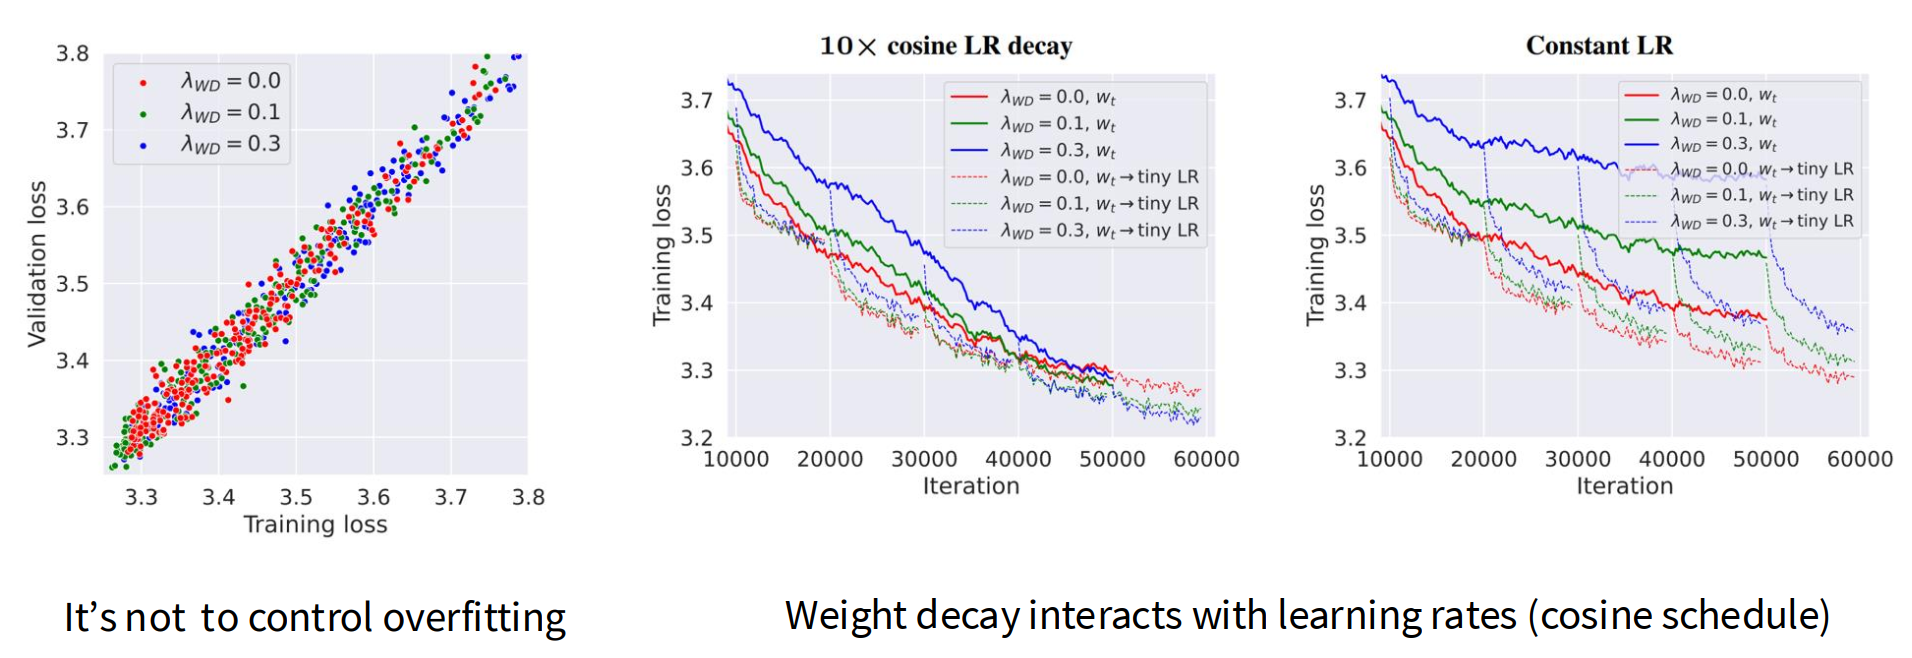

### 追求训练时的稳定性
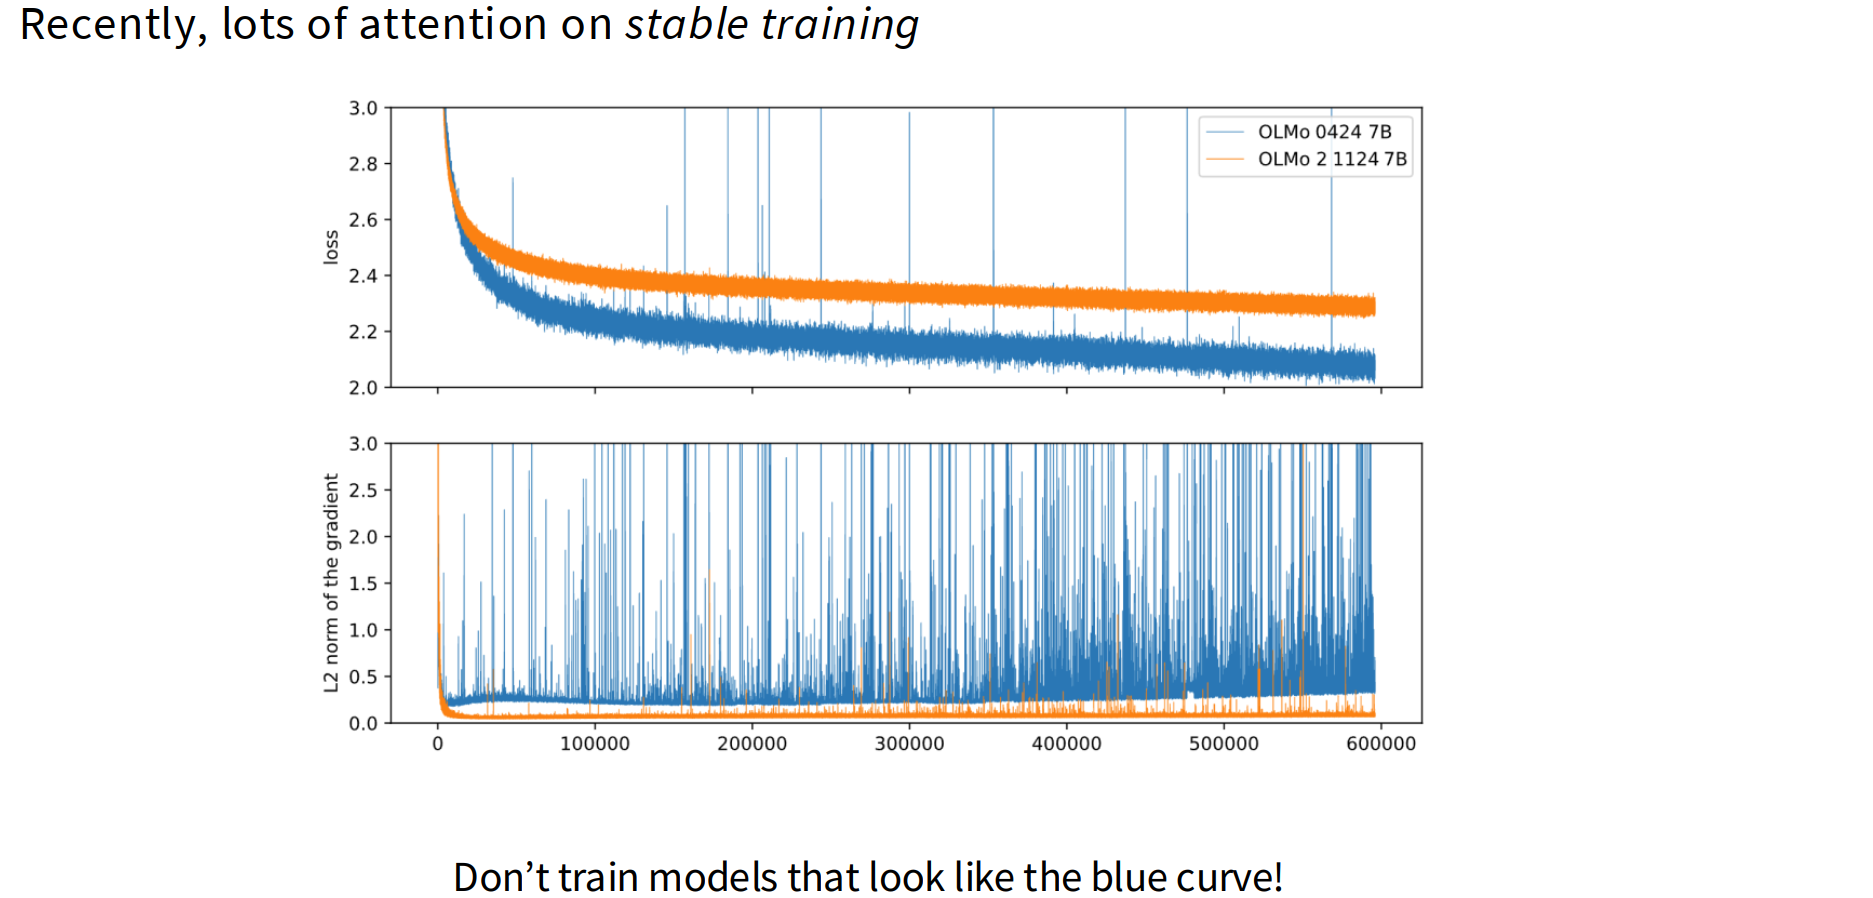
 - 我们更想要的是橙色的曲线而不是蓝色的
 - 虽然蓝色曲线loss更小，但是会有很多的梯度爆炸
 - 造成这个梯度爆炸的原因是softmax层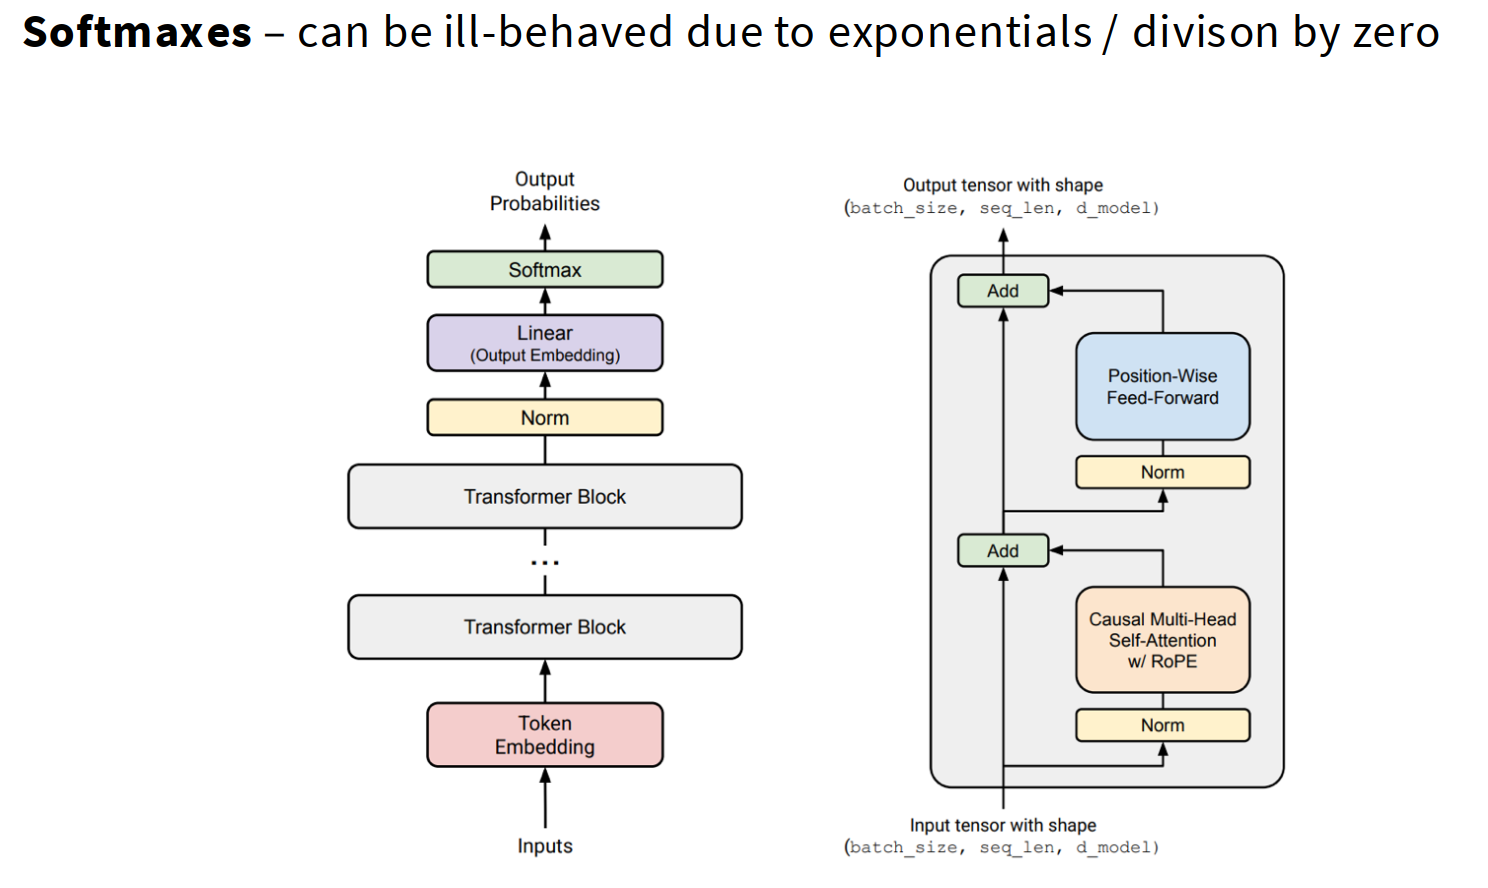


### softmax的计算方式
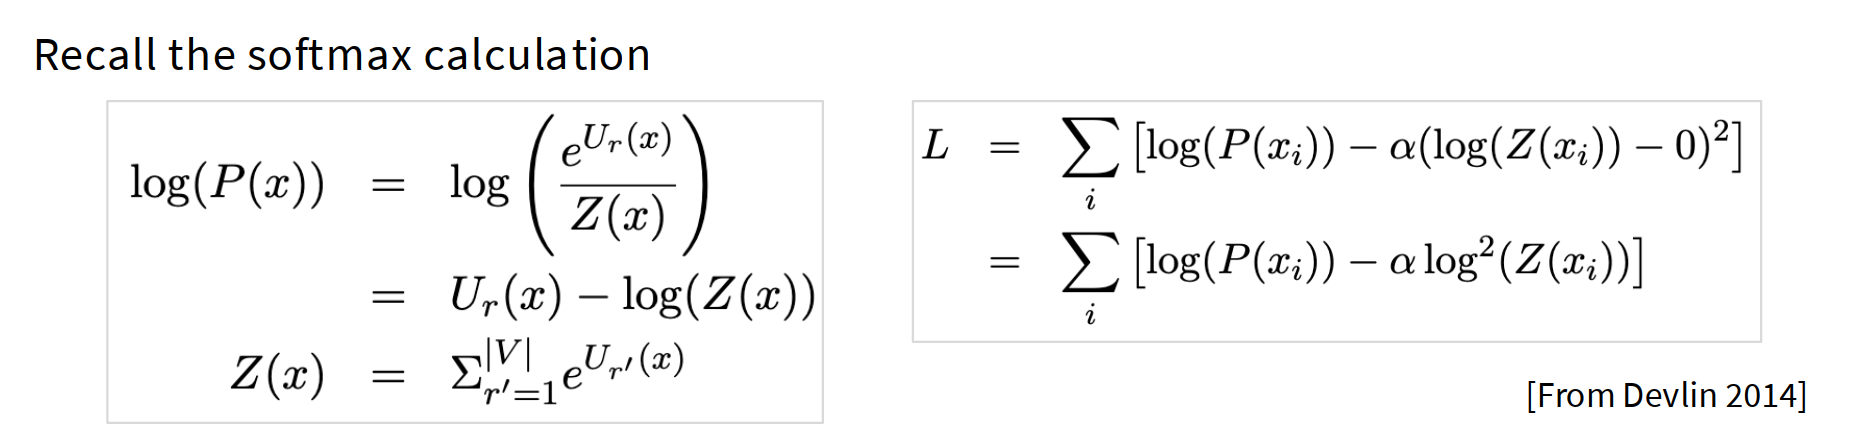
一个非常好的提高稳定性的干预措施：右侧的是为了辅助softmax使得Z趋近于1：Z-Loss trick

### 如何稳定输出softmax : **QK Norm**
 - The query and Keys are layer(RMS) normed before going into the softmax operation.

### Logit soft-capping:限制logits 的值
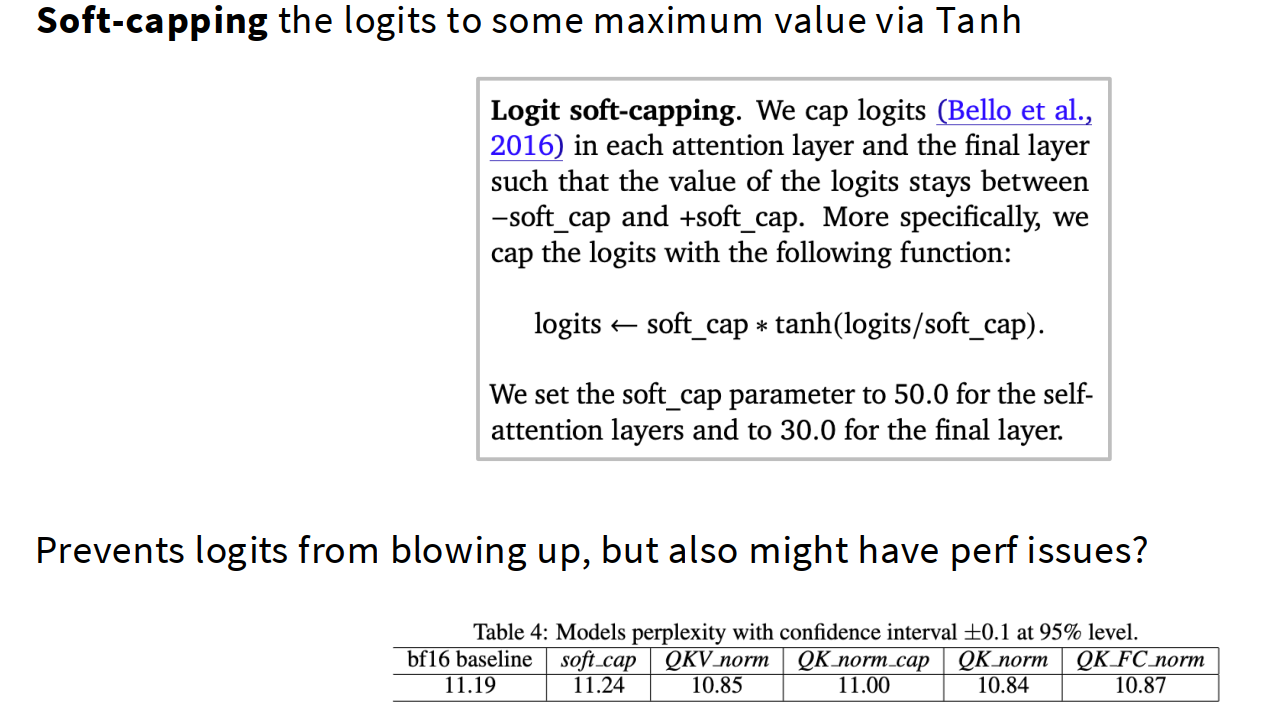

### attention heads
 - GQA/MQA:saving inference vcoests by reducing the number of heads
 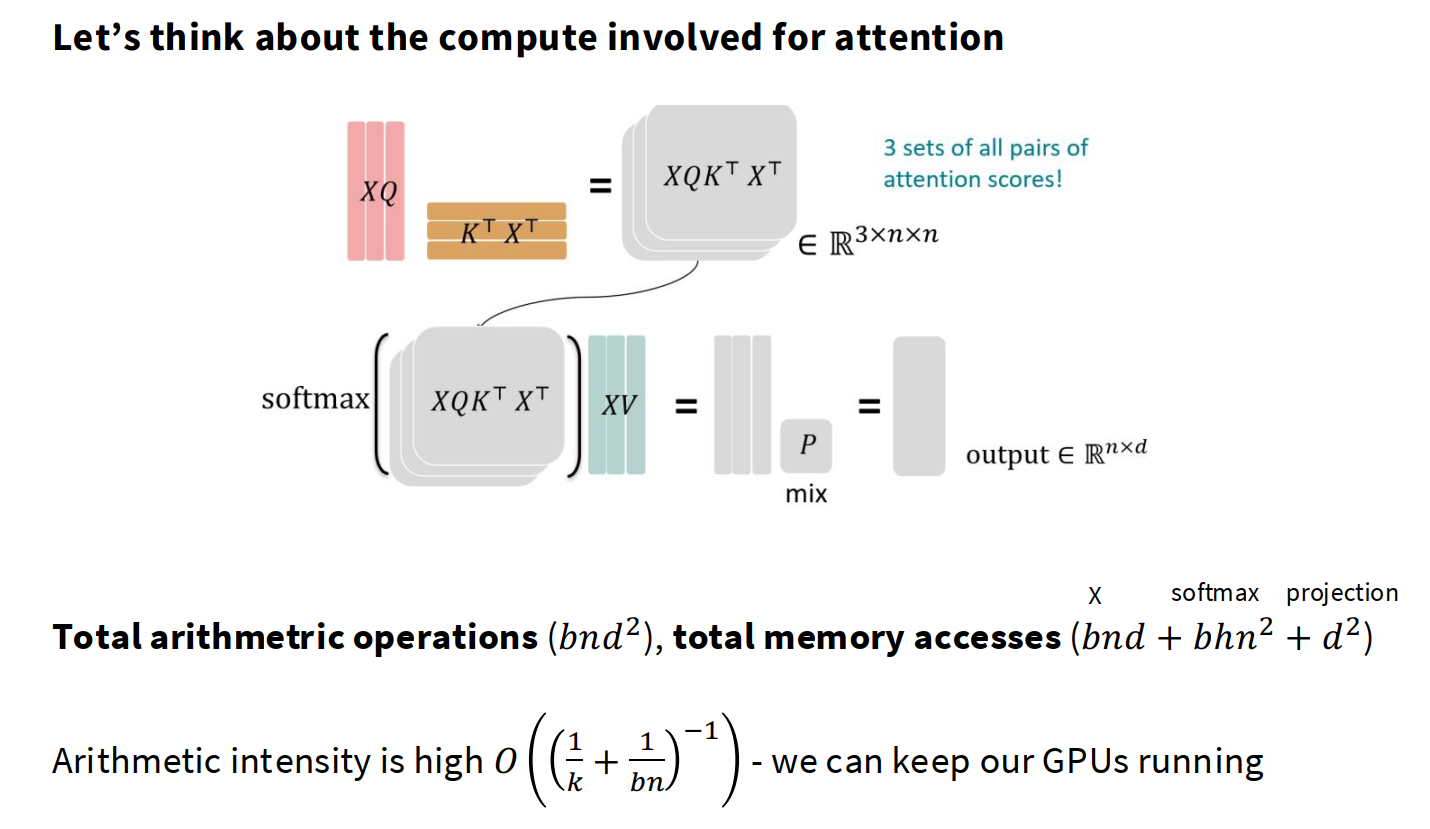
 memmory access的计算方法：b(batch size);h(head numbers);n(矩阵维度：activations you have)
  - 我们希望在一次内存访问中计算次数尽可能多（因为内存访问是比较昂贵的），所以诞生了arithmetric intensity（计算强度）这样的概念，这个值越高，那么GPU的running效率就越高（在一次内存访问中计算次数尽可能多）
  - 使用KV cache:增量生成K，V,保存所有中间计算过程，但是带来的问题就是下一次加载之前计算的所有K和V的时候，需要不断的访问内存，也会带来内存访问消耗

#### 推理成本权衡
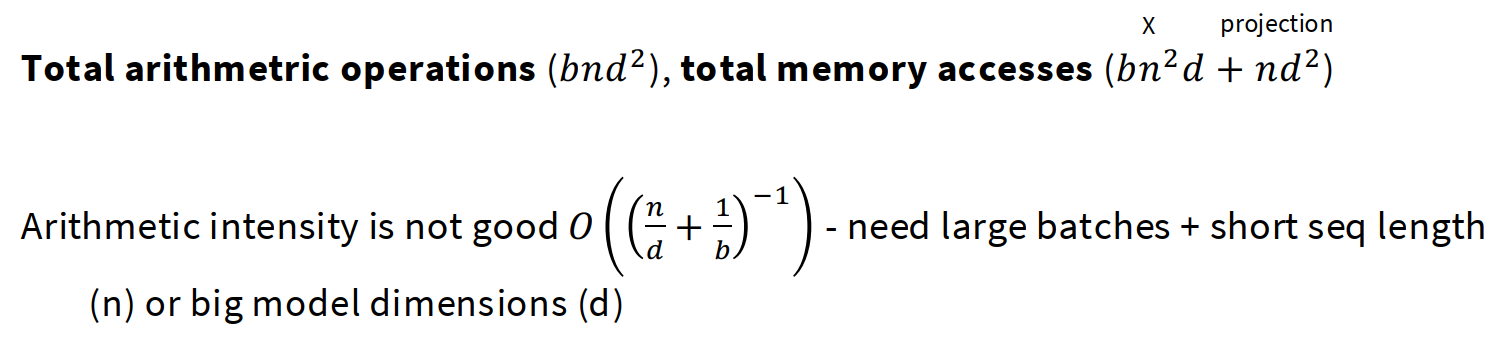
 - 为了解决在KV cache中存在的内存访问成本的问题，使用**MQA：fewer key dimensions**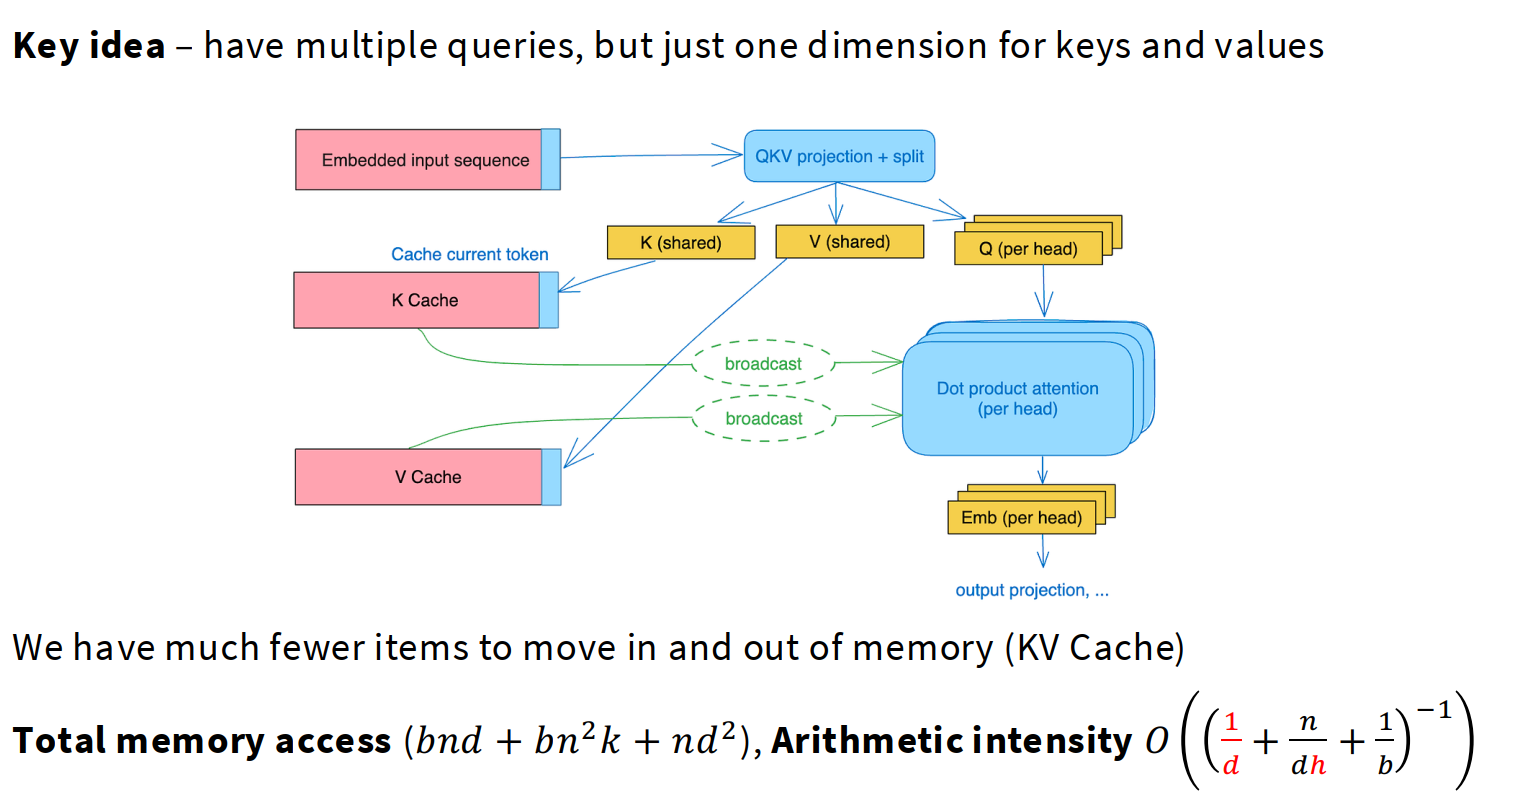
 - GQA:另一种思路
 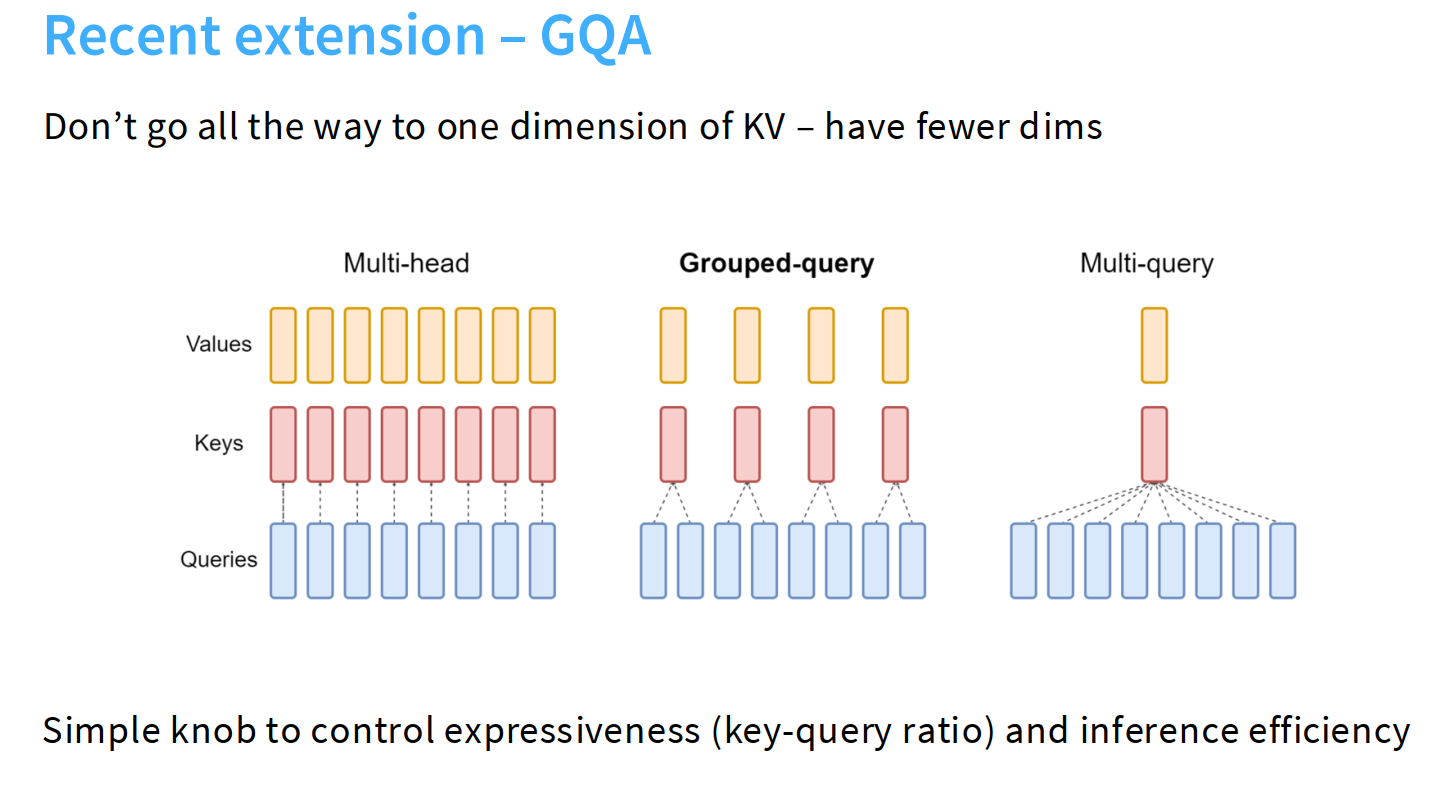


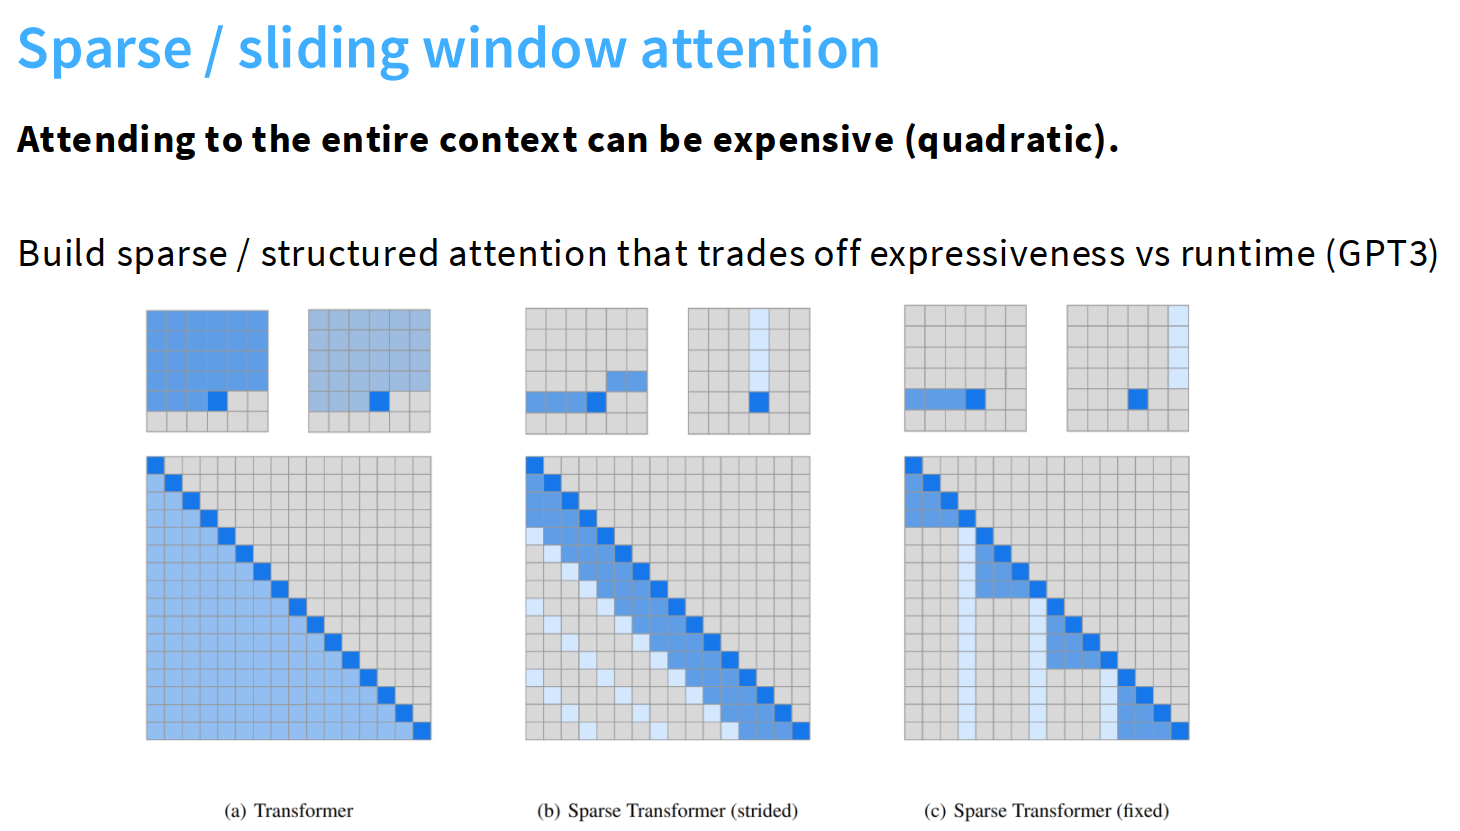
### sliding window attention
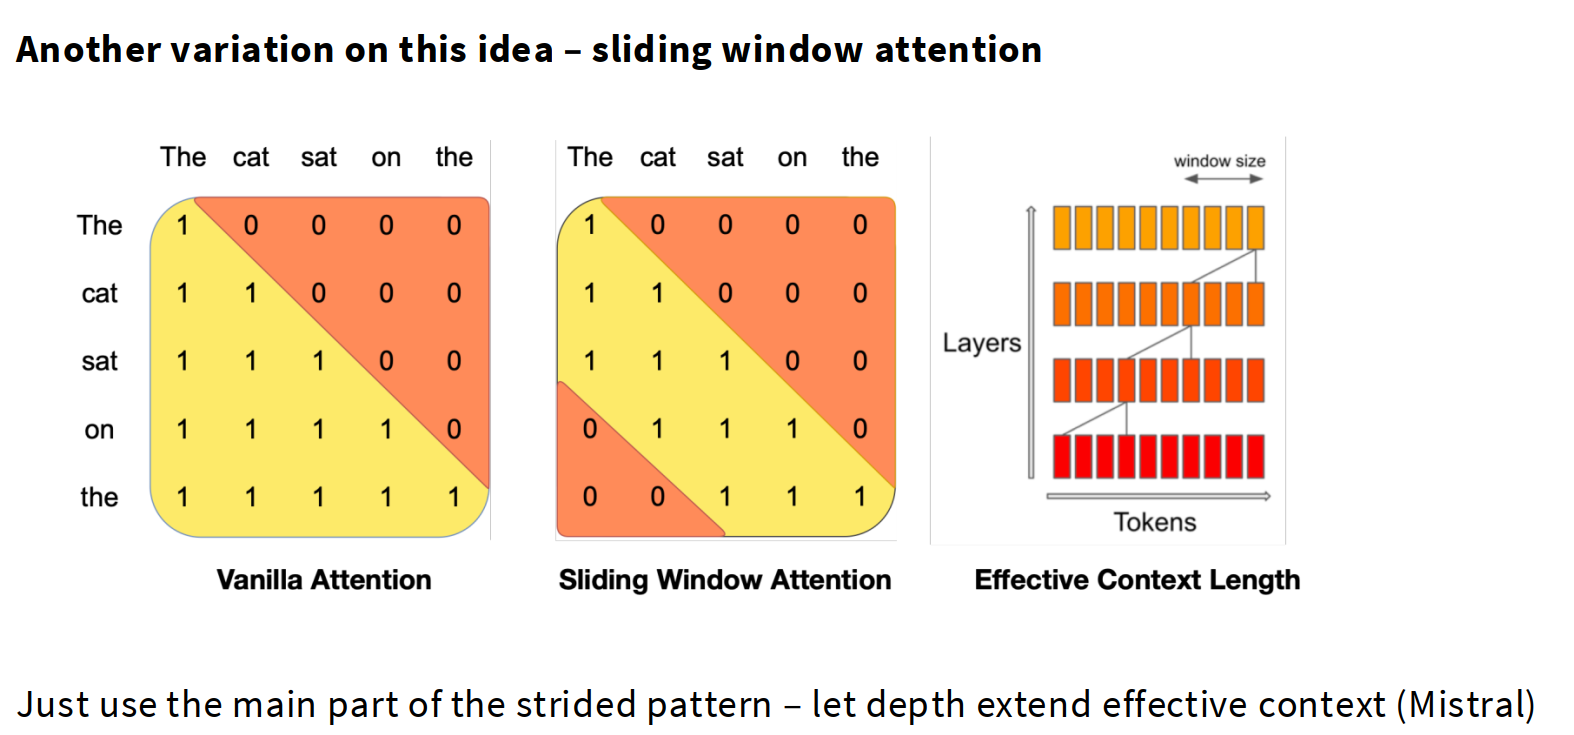
一种策略（控制系统方面的问题）：一组有四个transformer blocks,最底部的使用完全自注意力机制，没有位置嵌入；上面三个块使用带有RoPE的欢动窗口注意力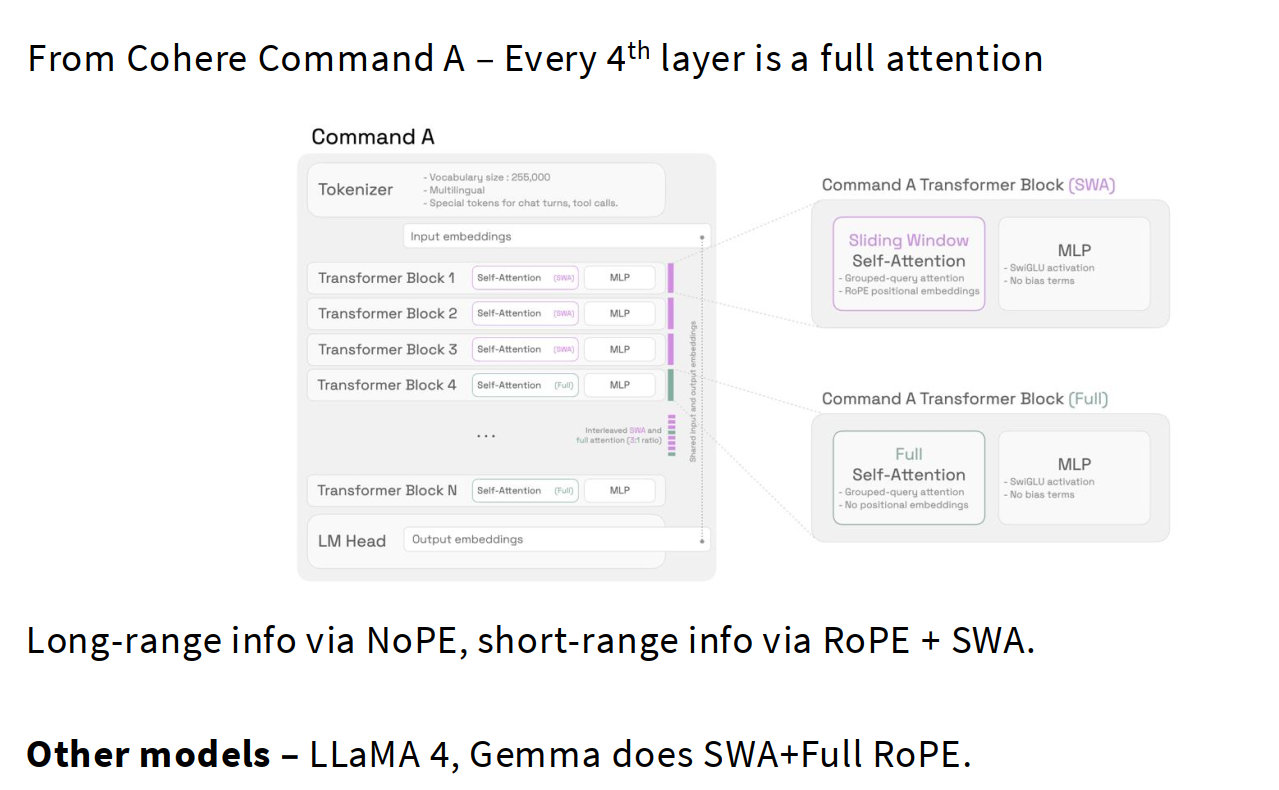